In [1]:
# Standard library imports
import random
import time
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.auto import tqdm

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# PyTorch Geometric imports
from torch_geometric.data import Data, Batch

from torch_geometric.loader import DataLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU

from torch_geometric.nn import global_mean_pool


/home/ensai/Documents/Smart Data Research Project/venv/lib/python3.12/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


## **1. Graph Construction**

In [2]:
# We're starting with inspecting one engine
df = pd.read_csv("../data/Project_ENSAI_2025/Cie_0_Engine0.csv")
df.head()

,cie_id,system_id,cycle,trigger_maintenance,trigger_shop_maintenance,trigger_usage_change,trigger_FOD,CRUISE_DTAMB,CRUISE_ALT,CRUISE_MACH,...,deg_CmpBst_s_mapEff_in,deg_CmpBst_s_mapWc_in,deg_CmpFan_s_mapEff_in,deg_CmpFan_s_mapWc_in,deg_CmpH_s_mapEff_in,deg_CmpH_s_mapWc_in,deg_TrbH_s_mapEff_in,deg_TrbH_s_mapWc_in,deg_TrbL_s_mapEff_in,deg_TrbL_s_mapWc_in
0,0,0,0,False,False,False,False,10.983,34964.527650,0.778101,...,-0.000609,-0.000191,-0.000091,-0.000022,-0.002123,0.000009,-0.001399,0.000129,-0.000461,-0.000011
1,0,0,1,False,False,False,False,10.944,35073.335577,0.799061,...,-0.000879,-0.000344,-0.000195,-0.000050,-0.003035,-0.000008,-0.002005,0.000152,-0.000701,-0.000064
2,0,0,2,False,False,False,False,10.163,34934.413052,0.766647,...,-0.001007,-0.000412,-0.000266,-0.000082,-0.003494,-0.000038,-0.002363,0.000171,-0.000840,-0.000085
3,0,0,3,False,False,False,False,9.285,35026.648235,0.792514,...,-0.001089,-0.000451,-0.000316,-0.000104,-0.003762,-0.000095,-0.002547,0.000229,-0.000892,-0.000131
4,0,0,4,False,False,False,False,10.226,34908.071055,0.780777,...,-0.001182,-0.000476,-0.000375,-0.000119,-0.003956,-0.000155,-0.002713,0.000261,-0.000984,-0.000165


### **1.1 Available Measurements**

We have several measurements from sensors available in the dataset. Each sensor records a measurement in the *CRUISE* and *TAKEOFF* phase, resulting in two measurements per sensor. The sensors can be broadly categorized in 5 groups:

- **AMBIENT** - context at fan inlet: `DTAMB`, `ALT`, `MACH`
- **COMMAND** - control input: `COMMAND`
- **HPC** - high‑pressure compressor: `HPC_Tin`, `HPC_Tout`, `HPC_Pout_st`, `HP_Nmech`
- **COMB** - combustor: `Fuel_flow`
- **LPT** - low‑pressure turbine: `LPT_Tin`


According to the flow of the engine, these sensors should be encoded as **AMBIENT/COMMAND** -> **HPC** -> **COMB** -> **LPT** in the final graph.

In [3]:
# Define all sensors explicitly (phase-specific)
sensor_cols = [
    # Ambient / context
    "CRUISE_DTAMB", "CRUISE_ALT", "CRUISE_MACH",
    "TAKEOFF_DTAMB", "TAKEOFF_ALT", "TAKEOFF_MACH",
    # Command
    "CRUISE_COMMAND", "TAKEOFF_COMMAND",
    # High-Pressure Compressor
    "CRUISE_DECKSMRHPC_Tout", "CRUISE_DECKSMRHPC_Tin", "CRUISE_DECKSMRHPC_Pout_st", "CRUISE_DECKSMRHP_Nmech",
    "TAKEOFF_DECKSMRHPC_Tout", "TAKEOFF_DECKSMRHPC_Tin", "TAKEOFF_DECKSMRHPC_Pout_st", "TAKEOFF_DECKSMRHP_Nmech",
    # Combustor
    "CRUISE_DECKSMRFuel_flow", "TAKEOFF_DECKSMRFuel_flow",
    # Low-Pressure Turbine
    "CRUISE_DECKSMRLPT_Tin", "TAKEOFF_DECKSMRLPT_Tin",
]

### **1.2 Edge Construction Rules**
To use represent this data as an undirected graph with as nodes the measurements, we need to specify how we connect the edges. We use the following set of rules to connect the different sensors together.

- **Phase pairing**: For each sensor, we connect the `CRUISE` and `TAKEOFF` measurement together.
- **Intra component**: Within each component/group, we connect all sensor together (within the same phase). This means that for **AMBIENT**, **COMMAND**, **HPC**, **COMB** and **LPT** we connect all the sensors within the group together.
- **Structural flow (within the same phase)**: We connect between the different groups according to the flow of the engine. This results in the following connections
  - `DTAMB`, `ALT`, `MACH` - `HPC_Tin`
  - `HPC_Tout`/`HPC_Pout_st`/`HP_Nmech` - `Fuel_flow`
  - `Fuel_flow` - `LPT_Tin`

A special case here is the **COMMAND** group, as it does not have a place in the engine. As commands primarily influence the rotation speed and fuel flow, we make the following connections
- `COMMAND` - `HP_Nmech`
- `COMMAND` - `Fuel_flow`

The code below implements the edge index of this graph.

In [4]:
def manual_edge_index(sensor_list, add_self_loops=False):
    sensor_to_idx = {sensor: idx for idx, sensor in enumerate(sensor_list)}
    edge_index = []

    def add_edge(a, b):
        if a in sensor_to_idx and b in sensor_to_idx:
            i, j = sensor_to_idx[a], sensor_to_idx[b]
            if i != j:
                edge_index.append((i, j))
                edge_index.append((j, i))  # bidirectional

    phases = ["CRUISE", "TAKEOFF"]

    for phase in phases:
        hpc_tin = f"{phase}_DECKSMRHPC_Tin"
        hpc_tout = f"{phase}_DECKSMRHPC_Tout"
        hpc_pout = f"{phase}_DECKSMRHPC_Pout_st"
        hp_nmech = f"{phase}_DECKSMRHP_Nmech"
        fuel_flow = f"{phase}_DECKSMRFuel_flow"
        lpt_tin = f"{phase}_DECKSMRLPT_Tin"
        command = f"{phase}_COMMAND"
        
        dtamb = f"{phase}_DTAMB"
        alt = f"{phase}_ALT"
        mach = f"{phase}_MACH"

        # Ambient variables connected to each other
        add_edge(dtamb, alt)
        add_edge(dtamb, mach)
        add_edge(alt, mach)

        # Ambient/context into HPC_Tin
        add_edge(dtamb, hpc_tin)
        add_edge(alt, hpc_tin)
        add_edge(mach, hpc_tin)

        # HPC core fully connected (clique of 4)
        add_edge(hpc_tin, hpc_tout)
        add_edge(hpc_tin, hpc_pout)
        add_edge(hpc_tin, hp_nmech)
        add_edge(hpc_tout, hpc_pout)
        add_edge(hpc_tout, hp_nmech)
        add_edge(hpc_pout, hp_nmech)

        # HPC outputs to fuel
        add_edge(hpc_tout, fuel_flow)
        add_edge(hpc_pout, fuel_flow)
        add_edge(hp_nmech, fuel_flow)

        # Fuel to turbine
        add_edge(fuel_flow, lpt_tin)

        # Command influences
        add_edge(command, hp_nmech)
        add_edge(command, fuel_flow)

    # Cross-phase pairing: same variable CRUISE - TAKEOFF
    for sensor in sensor_list:
        if sensor.startswith("CRUISE"):
            add_edge(sensor, sensor.replace("CRUISE", "TAKEOFF"))
    
    if add_self_loops:
        # Add self-loops for all nodes
        for sensor in sensor_list:
            idx = sensor_to_idx[sensor]
            edge_index.append((idx, idx))

    return edge_index, sensor_to_idx

# Build edge index
edge_index, sensor_to_idx = manual_edge_index(sensor_cols, add_self_loops=True)

We construct an undirected `networkx.Graph` using the bidirectional `edge_index` for quick inspection.

In [5]:
# Build a simple undirected view for inspection
G = nx.Graph()

# Add nodes
for sensor in sensor_cols:
    G.add_node(sensor_to_idx[sensor], label=sensor)

# Add edges
G.add_edges_from(edge_index)

for source, target in G.edges():
    source = G.nodes[source]['label']
    target = G.nodes[target]['label']
    print(f"{source} - {target}")

CRUISE_DTAMB - CRUISE_ALT
CRUISE_DTAMB - CRUISE_MACH
CRUISE_DTAMB - CRUISE_DECKSMRHPC_Tin
CRUISE_DTAMB - TAKEOFF_DTAMB
CRUISE_DTAMB - CRUISE_DTAMB
CRUISE_ALT - CRUISE_MACH
CRUISE_ALT - CRUISE_DECKSMRHPC_Tin
CRUISE_ALT - TAKEOFF_ALT
CRUISE_ALT - CRUISE_ALT
CRUISE_MACH - CRUISE_DECKSMRHPC_Tin
CRUISE_MACH - TAKEOFF_MACH
CRUISE_MACH - CRUISE_MACH
TAKEOFF_DTAMB - TAKEOFF_ALT
TAKEOFF_DTAMB - TAKEOFF_MACH
TAKEOFF_DTAMB - TAKEOFF_DECKSMRHPC_Tin
TAKEOFF_DTAMB - TAKEOFF_DTAMB
TAKEOFF_ALT - TAKEOFF_MACH
TAKEOFF_ALT - TAKEOFF_DECKSMRHPC_Tin
TAKEOFF_ALT - TAKEOFF_ALT
TAKEOFF_MACH - TAKEOFF_DECKSMRHPC_Tin
TAKEOFF_MACH - TAKEOFF_MACH
CRUISE_COMMAND - CRUISE_DECKSMRHP_Nmech
CRUISE_COMMAND - CRUISE_DECKSMRFuel_flow
CRUISE_COMMAND - TAKEOFF_COMMAND
CRUISE_COMMAND - CRUISE_COMMAND
TAKEOFF_COMMAND - TAKEOFF_DECKSMRHP_Nmech
TAKEOFF_COMMAND - TAKEOFF_DECKSMRFuel_flow
TAKEOFF_COMMAND - TAKEOFF_COMMAND
CRUISE_DECKSMRHPC_Tout - CRUISE_DECKSMRHPC_Tin
CRUISE_DECKSMRHPC_Tout - CRUISE_DECKSMRHPC_Pout_st
CRUISE_DEC

### **1.3 Graph visualization**
Below we plot the graph with to visualize our results. For visibility purposes, we plot the graph only for one phase, but one should take in mind that we actually have such a graph for each of the phases and connect the same sensor in different phases together.

Note: 10 self-loops exist in the graph data but are not drawn


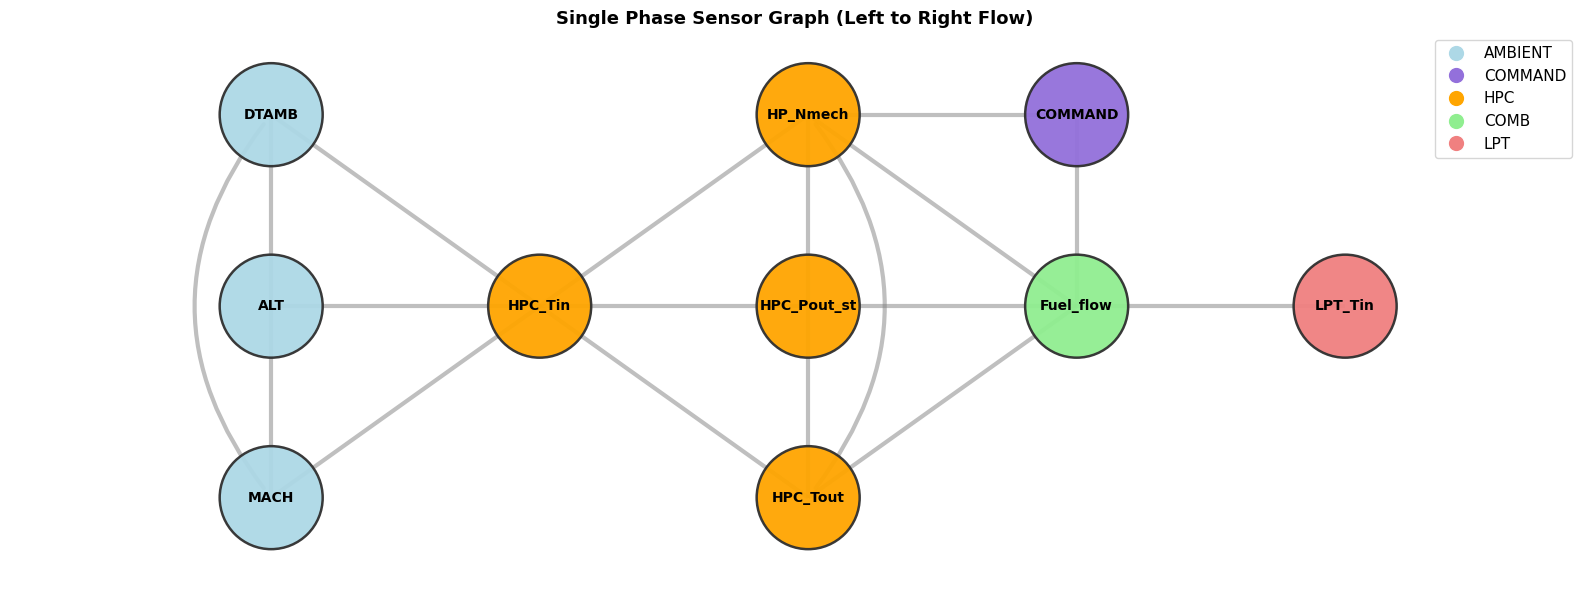

In [6]:
def visualize_engine_graph(G):
    # Extract TAKEOFF nodes from existing graph
    takeoff_nodes = [n for n, data in G.nodes(data=True) if "TAKEOFF" in data.get("label", "")]
    G_takeoff = G.subgraph(takeoff_nodes).copy()

    group_colors = {
        "AMBIENT": "lightblue",
        "COMMAND": "mediumpurple",
        "HPC": "orange",
        "COMB": "lightgreen",
        "LPT": "lightcoral",
        "OTHER": "gray",
    }

    def get_group(sensor):
        if any(tag in sensor for tag in ["DTAMB", "ALT", "MACH"]):
            return "AMBIENT"
        if "COMMAND" in sensor:
            return "COMMAND"
        if "HPC" in sensor or "HP_Nmech" in sensor:
            return "HPC"
        if "Fuel_flow" in sensor:
            return "COMB"
        if "LPT_Tin" in sensor:
            return "LPT"
        return "OTHER"

    # Manual layout with explicit positioning
    pos = {}
    labels = {}
    nodes_list = list(G_takeoff.nodes())

    # Define column positions (x) and vertical stacking
    col_x = {
        "ambient": 0,
        "hpc_tin": 2,
        "hpc_core": 4,
        "fuel": 6,
        "lpt": 8,
    }

    # Compute node positions and labels from existing graph attributes
    for idx in nodes_list:
        sensor = G.nodes[idx]["label"]
        group = get_group(sensor)

        if "DTAMB" in sensor:
            pos[idx] = (col_x["ambient"], 2)
        elif "ALT" in sensor:
            pos[idx] = (col_x["ambient"], 1)
        elif "MACH" in sensor:
            pos[idx] = (col_x["ambient"], 0)
        elif "HPC_Tin" in sensor:
            pos[idx] = (col_x["hpc_tin"], 1)
        elif "HP_Nmech" in sensor:
            pos[idx] = (col_x["hpc_core"], 2)
        elif "HPC_Pout_st" in sensor:
            pos[idx] = (col_x["hpc_core"], 1)
        elif "HPC_Tout" in sensor:
            pos[idx] = (col_x["hpc_core"], 0)
        elif "COMMAND" in sensor:
            pos[idx] = (col_x["fuel"], 2)
        elif "Fuel_flow" in sensor:
            pos[idx] = (col_x["fuel"], 1)
        elif "LPT_Tin" in sensor:
            pos[idx] = (col_x["lpt"], 1)
        else:
            pos[idx] = (5, 5)

        # Shorten labels for readability
        labels[idx] = sensor.replace("TAKEOFF_", "").replace("DECKSMR", "")

    # Build color list aligned with nodes_list
    node_colors = []
    for idx in nodes_list:
        sensor = G.nodes[idx]["label"]
        node_colors.append(group_colors[get_group(sensor)])

    fig, ax = plt.subplots(figsize=(16, 6))

    # Draw nodes
    nx.draw_networkx_nodes(
        G_takeoff,
        pos=pos,
        nodelist=nodes_list,
        node_color=node_colors,
        node_size=5500,
        edgecolors="#2f2f2f",
        linewidths=1.8,
        alpha=0.95,
        ax=ax,
    )

    # Draw labels
    nx.draw_networkx_labels(
        G_takeoff,
        pos=pos,
        labels={n: labels[n] for n in nodes_list},
        font_size=10,
        font_weight="bold",
        ax=ax,
    )

    # Separate edges into self-loops, curved, and straight for drawing
    self_loops = []
    curved_edges = []
    straight_edges = []

    for u, v in G_takeoff.edges():
        if u == v:
            # Self-loop
            self_loops.append((u, v))
        else:
            y_diff = abs(pos[u][1] - pos[v][1])
            x_diff = abs(pos[u][0] - pos[v][0])
            if x_diff < 0.1 and y_diff > 1.5:
                curved_edges.append((u, v))
            else:
                straight_edges.append((u, v))

    # Draw straight edges
    nx.draw_networkx_edges(
        G_takeoff,
        pos=pos,
        edgelist=straight_edges,
        edge_color="gray",
        width=3.0,
        alpha=0.5,
        ax=ax,
    )

    # Draw curved edges with arrows=True to enable connectionstyle
    nx.draw_networkx_edges(
        G_takeoff,
        pos=pos,
        edgelist=curved_edges,
        edge_color="gray",
        width=3.0,
        alpha=0.5,
        arrows=True,
        arrowsize=10,
        arrowstyle='-',
        connectionstyle="arc3,rad=0.4",
        ax=ax,
    )
    
    # Self-loops exist in the edge_index but are not visible in this visualization
    if self_loops:
        print(f"Note: {len(self_loops)} self-loops exist in the graph data but are not drawn")

    # Add padding around the content
    ax.margins(0.15)

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='AMBIENT', markerfacecolor='lightblue', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='COMMAND', markerfacecolor='mediumpurple', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='HPC', markerfacecolor='orange', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='COMB', markerfacecolor='lightgreen', markersize=12),
        plt.Line2D([0], [0], marker='o', color='w', label='LPT', markerfacecolor='lightcoral', markersize=12),
    ]
    ax.legend(handles=legend_elements, loc="upper right", fontsize=11, frameon=True)
    ax.set_title("Single Phase Sensor Graph (Left to Right Flow)", fontsize=13, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_engine_graph(G)

![](../engine_simulator/turbine.jpeg)

## **2. GNN Graph Dataset Construction**

This section builds a PyTorch Geometric dataset from the engine CSV files.
 

### **2.1 Data Exploration**

Before building the full pipeline, let's explore:

1. How many CSV files we have
2. Label distribution across files

In [7]:
# Get all CSV files
data_dir = Path("../data/Project_ENSAI_2025")
csv_files = sorted(data_dir.glob("*.csv"))

print(f"Total CSV files: {len(csv_files)}")

Total CSV files: 249


In [8]:
# Load and concatenate all data
data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
data.head()

,cie_id,system_id,cycle,trigger_maintenance,trigger_shop_maintenance,trigger_usage_change,trigger_FOD,CRUISE_DTAMB,CRUISE_ALT,CRUISE_MACH,...,deg_CmpBst_s_mapEff_in,deg_CmpBst_s_mapWc_in,deg_CmpFan_s_mapEff_in,deg_CmpFan_s_mapWc_in,deg_CmpH_s_mapEff_in,deg_CmpH_s_mapWc_in,deg_TrbH_s_mapEff_in,deg_TrbH_s_mapWc_in,deg_TrbL_s_mapEff_in,deg_TrbL_s_mapWc_in
0,0,0,0,False,False,False,False,10.983,34964.527650,0.778101,...,-0.000609,-0.000191,-0.000091,-0.000022,-0.002123,0.000009,-0.001399,0.000129,-0.000461,-0.000011
1,0,0,1,False,False,False,False,10.944,35073.335577,0.799061,...,-0.000879,-0.000344,-0.000195,-0.000050,-0.003035,-0.000008,-0.002005,0.000152,-0.000701,-0.000064
2,0,0,2,False,False,False,False,10.163,34934.413052,0.766647,...,-0.001007,-0.000412,-0.000266,-0.000082,-0.003494,-0.000038,-0.002363,0.000171,-0.000840,-0.000085
3,0,0,3,False,False,False,False,9.285,35026.648235,0.792514,...,-0.001089,-0.000451,-0.000316,-0.000104,-0.003762,-0.000095,-0.002547,0.000229,-0.000892,-0.000131
4,0,0,4,False,False,False,False,10.226,34908.071055,0.780777,...,-0.001182,-0.000476,-0.000375,-0.000119,-0.003956,-0.000155,-0.002713,0.000261,-0.000984,-0.000165


In [9]:
# Display number of rows and columns
print(f"Data shape: {data.shape}")

Data shape: (249000, 52)


There are 4 labels of interest: `corrosion`, `erosion`, `fouling` and `tip_clearance`. Note that the `normal` label is not of interest, as it reflects normal degradation and is 1 for every observation in the dataset.

In [10]:
# Define the columns corresponding to labels
fault_cols = ["corrosion", "erosion", "fouling", "tip_clearance"]

# Calculate statistics
total_cycles = len(data)
row_sums = data[fault_cols].sum(axis=1)
multi_label_rows = (row_sums > 1).sum()
no_label_rows = (row_sums == 0).sum()

# Display results as table
print(f"{'Label':<15} {'1s Count':>12} {'%':>8} {'0s Count':>12}")
print("-" * 50)
for col in fault_cols:
    ones = (data[col] == 1).sum()
    zeros = (data[col] == 0).sum()
    pct = 100 * ones / total_cycles
    print(f"{col:<15} {ones:>12,} {pct:>7.1f}% {zeros:>12,}")

print(f"\nMulti-label rows (>1 fault): {multi_label_rows:,}")

Label               1s Count        %     0s Count
--------------------------------------------------
corrosion             44,323    17.8%      204,677
erosion               51,266    20.6%      197,734
fouling               53,319    21.4%      195,681
tip_clearance         47,670    19.1%      201,330

Multi-label rows (>1 fault): 32,712


We now construct a new label column which reflects no fault.

In [11]:
# has_fault = 1 if any actual fault is present
data['no_fault'] = (row_sums == 0).astype(float)

print(data[fault_cols + ['no_fault']].head(5))
print(f"\nNo fault: {(data['no_fault']==1).sum():,} cycles ({100*(data['no_fault']==1).sum()/len(data):.1f}%)")

   corrosion  erosion  fouling  tip_clearance  no_fault
0        0.0      1.0      1.0            0.0       0.0
1        0.0      1.0      1.0            0.0       0.0
2        0.0      1.0      1.0            0.0       0.0
3        0.0      1.0      1.0            0.0       0.0
4        0.0      1.0      1.0            0.0       0.0

No fault: 94,534 cycles (38.0%)


We now select only the label columns, identifiers and sensors that will enter the classification models.

In [12]:
labels = fault_cols + ['no_fault']

data = data[['cie_id', 'system_id', 'cycle'] + labels + sensor_cols]
print(data.shape)
data.head(5)

(249000, 28)


,cie_id,system_id,cycle,corrosion,erosion,fouling,tip_clearance,no_fault,CRUISE_DTAMB,CRUISE_ALT,...,CRUISE_DECKSMRHPC_Pout_st,CRUISE_DECKSMRHP_Nmech,TAKEOFF_DECKSMRHPC_Tout,TAKEOFF_DECKSMRHPC_Tin,TAKEOFF_DECKSMRHPC_Pout_st,TAKEOFF_DECKSMRHP_Nmech,CRUISE_DECKSMRFuel_flow,TAKEOFF_DECKSMRFuel_flow,CRUISE_DECKSMRLPT_Tin,TAKEOFF_DECKSMRLPT_Tin
0,0,0,0,0.0,1.0,1.0,0.0,0.0,10.983,34964.527650,...,1.376776e+06,19426.289709,893.835901,386.299476,3.524797e+06,20053.515013,0.374287,1.026361,1126.960037,1267.199434
1,0,0,1,0.0,1.0,1.0,0.0,0.0,10.944,35073.335577,...,1.393767e+06,19436.961345,893.693939,386.377987,3.531900e+06,20049.397875,0.385616,1.030432,1126.629725,1271.272434
2,0,0,2,0.0,1.0,1.0,0.0,0.0,10.163,34934.413052,...,1.368314e+06,19379.211732,893.767254,386.648326,3.512176e+06,20030.507381,0.370405,1.024302,1126.199604,1266.950751
3,0,0,3,0.0,1.0,1.0,0.0,0.0,9.285,35026.648235,...,1.396163e+06,19369.899845,892.020629,386.069464,3.503819e+06,19994.356800,0.380465,1.026072,1121.898393,1268.765848
4,0,0,4,0.0,1.0,1.0,0.0,0.0,10.226,34908.071055,...,1.387789e+06,19376.012037,893.995937,386.338576,3.510192e+06,19999.807752,0.373236,1.030714,1125.583354,1267.832530


### **2.2 PyTorch Geometric Temporal Dataset**
We now start by constructing the dataset object so that it can be used by the models from PyTorch Geometric Temporal. To construct the dataset, we take the following things into account:

1. The data contains different turbine engines from different companies. The id's are encoded in the `system_id` and `cie_id` respectively, where the `system_id` is company specific meaning that different engines from different companies might have the same `system_id`.
2. For each engine, we take a rolling of `WINDOW_SIZE` with step size `STEP` over the time series. To determine the label for this series, we simply take the most frequent occuring fault. If there is a tie, we choose randomly.
3. The train/validation/test set has to be split made based on engines, so that each set contains engines that are not present in the other sets. This ensures that we have no data leakage from the train set to the validation or test set.
4. The data has to be loaded via a `DataLoader`, for easy use.

In [ ]:
# Configuration parameters
WINDOW_SIZE = 10  # Number of time steps in each sequence
STEP = 1  # Step size for rolling window
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

In [14]:
def create_engine_splits(data, train_ratio=0.7, val_ratio=0.15, seed=42):
    """
    Split engines into train/val/test groups.
    
    Returns:
        train_engines, val_engines, test_engines (lists of (cie_id, system_id) tuples)
    """
    # Get unique engines
    all_engines = data.groupby(['cie_id', 'system_id']).size().index.tolist()
    
    # Split engines
    test_size = 1.0 - train_ratio - val_ratio
    train_val_engines, test_engines = train_test_split(
        all_engines, test_size=test_size, random_state=seed
    )
    val_size_adjusted = val_ratio / (train_ratio + val_ratio)
    train_engines, val_engines = train_test_split(
        train_val_engines, test_size=val_size_adjusted, random_state=seed
    )
    
    print(f"Total engines: {len(all_engines)}")
    print(f"  Train: {len(train_engines)} engines")
    print(f"  Val:   {len(val_engines)} engines")
    print(f"  Test:  {len(test_engines)} engines")
    
    return train_engines, val_engines, test_engines


# Split engines
train_engines, val_engines, test_engines = create_engine_splits(
    data, TRAIN_RATIO, VAL_RATIO
)

Total engines: 249
  Train: 173 engines
  Val:   38 engines
  Test:  38 engines


### **2.2.1 Base Dataset Class**

This base class contains the shared logic for creating temporal windows from engine data.

In [15]:
class BaseEngineDataset(Dataset):
    """Base class for creating temporal windows from engine data."""
    
    def __init__(self, data, sensor_cols, label_cols, window_size=10, step=1, engine_filter=None):
        """
        Args:
            data: DataFrame with engine data
            sensor_cols: List of sensor column names
            label_cols: List of label column names
            window_size: Number of time steps per window
            step: Step size for sliding window
            engine_filter: Optional list of (cie_id, system_id) tuples to include
        """
        # Pre-filter data if engine_filter is provided
        if engine_filter is not None:
            mask = data.set_index(['cie_id', 'system_id']).index.isin(engine_filter)
            self.data = data[mask].reset_index(drop=True)
        else:
            self.data = data
            
        self.sensor_cols = sensor_cols
        self.label_cols = label_cols
        self.window_size = window_size
        self.step = step
        self.samples = []
        self.prepare_samples()
    
    def prepare_samples(self):
        """Create temporal windows - to be implemented by subclasses."""
        raise NotImplementedError
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]
    
    def save(self, filepath):
        """Save dataset to disk."""
        torch.save({
            'samples': self.samples,
            'sensor_cols': self.sensor_cols,
            'label_cols': self.label_cols,
            'window_size': self.window_size,
            'step': self.step
        }, filepath)
        print(f"Dataset saved to {filepath}")
    
    @classmethod
    def load(cls, filepath):
        """Load dataset from disk."""
        data = torch.load(filepath)
        dataset = cls.__new__(cls)
        dataset.samples = data['samples']
        dataset.sensor_cols = data['sensor_cols']
        dataset.label_cols = data['label_cols']
        dataset.window_size = data['window_size']
        dataset.step = data['step']
        print(f"Dataset loaded from {filepath}")
        return dataset

print("Base dataset class defined.")

Base dataset class defined.


### **2.2.2 Dataset Classes for Different Model Types**

In [16]:
class EngineDatasetPyGTemporal(BaseEngineDataset):
    """Dataset for PyTorch Geometric Temporal models (e.g., GConvGRU).
    
    Returns: Data(x=[num_nodes, 1, window_size], edge_index=[2, num_edges], y=long)
    DataLoader: Use torch_geometric.loader.DataLoader
    """
    
    def __init__(self, data, sensor_cols, label_cols, edge_index, window_size=10, step=1, engine_filter=None):
        self.edge_index = edge_index
        super().__init__(data, sensor_cols, label_cols, window_size, step, engine_filter)
    
    def prepare_samples(self):
        edge_index_tensor = torch.tensor(self.edge_index, dtype=torch.long).t().contiguous()
        
        grouped = self.data.groupby(['cie_id', 'system_id'])
        for (cie_id, system_id), group in tqdm(grouped, desc="Preparing PyG Temporal dataset"):
            group = group.sort_values(by='cycle').reset_index(drop=True)
            num_cycles = len(group)

            for start in range(0, num_cycles - self.window_size + 1, self.step):
                end = start + self.window_size
                window_data = group.iloc[start:end]

                # x shape: [window_size, num_nodes] -> transpose -> [num_nodes, window_size] -> unsqueeze -> [num_nodes, 1, window_size]
                x = torch.tensor(window_data[self.sensor_cols].values, dtype=torch.float).t().unsqueeze(1)

                # Label
                label_counts = window_data[self.label_cols].sum(axis=0)
                max_count = label_counts.max()
                tied_labels = label_counts[label_counts == max_count].index.tolist()
                most_common_label = random.choice(tied_labels)
                label_idx = self.label_cols.index(most_common_label)
                y = torch.tensor(label_idx, dtype=torch.long)

                graph = Data(x=x, edge_index=edge_index_tensor, y=y)
                self.samples.append(graph)


class EngineDatasetPyGStatic(BaseEngineDataset):
    """Dataset for PyTorch Geometric static models (e.g., GCN, GAT).
    
    Returns: Data(x=[num_nodes, num_features], edge_index=[2, num_edges], y=long)
    Each node has window_size features (the time series at that sensor).
    DataLoader: Use torch_geometric.loader.DataLoader
    """
    
    def __init__(self, data, sensor_cols, label_cols, edge_index, window_size=10, step=1, engine_filter=None):
        self.edge_index = edge_index
        super().__init__(data, sensor_cols, label_cols, window_size, step, engine_filter)
    
    def prepare_samples(self):
        edge_index_tensor = torch.tensor(self.edge_index, dtype=torch.long).t().contiguous()
        
        grouped = self.data.groupby(['cie_id', 'system_id'])
        for (cie_id, system_id), group in tqdm(grouped, desc="Preparing PyG Static dataset"):
            group = group.sort_values(by='cycle').reset_index(drop=True)
            num_cycles = len(group)

            for start in range(0, num_cycles - self.window_size + 1, self.step):
                end = start + self.window_size
                window_data = group.iloc[start:end]

                # x shape: [window_size, num_nodes] -> transpose -> [num_nodes, window_size]
                x = torch.tensor(window_data[self.sensor_cols].values, dtype=torch.float).t()

                # Label
                label_counts = window_data[self.label_cols].sum(axis=0)
                max_count = label_counts.max()
                tied_labels = label_counts[label_counts == max_count].index.tolist()
                most_common_label = random.choice(tied_labels)
                label_idx = self.label_cols.index(most_common_label)
                y = torch.tensor(label_idx, dtype=torch.long)

                graph = Data(x=x, edge_index=edge_index_tensor, y=y)
                self.samples.append(graph)


class EngineDatasetSequential(BaseEngineDataset):
    """Dataset for sequential models (LSTM, GRU, Transformer).
    
    Returns: (x=[window_size, num_sensors], y=long)
    DataLoader: Use torch.utils.data.DataLoader
    """
    
    def prepare_samples(self):
        grouped = self.data.groupby(['cie_id', 'system_id'])
        for (cie_id, system_id), group in tqdm(grouped, desc="Preparing Sequential dataset"):
            group = group.sort_values(by='cycle').reset_index(drop=True)
            num_cycles = len(group)

            for start in range(0, num_cycles - self.window_size + 1, self.step):
                end = start + self.window_size
                window_data = group.iloc[start:end]

                # x shape: [window_size, num_sensors]
                x = torch.tensor(window_data[self.sensor_cols].values, dtype=torch.float)

                # Label
                label_counts = window_data[self.label_cols].sum(axis=0)
                max_count = label_counts.max()
                tied_labels = label_counts[label_counts == max_count].index.tolist()
                most_common_label = random.choice(tied_labels)
                label_idx = self.label_cols.index(most_common_label)
                y = torch.tensor(label_idx, dtype=torch.long)

                self.samples.append((x, y))


class EngineDatasetFlattened(BaseEngineDataset):
    """Dataset for fully connected models (MLP).
    
    Returns: (x=[window_size * num_sensors], y=long)
    DataLoader: Use torch.utils.data.DataLoader
    """
    
    def prepare_samples(self):
        grouped = self.data.groupby(['cie_id', 'system_id'])
        for (cie_id, system_id), group in tqdm(grouped, desc="Preparing Flattened dataset"):
            group = group.sort_values(by='cycle').reset_index(drop=True)
            num_cycles = len(group)

            for start in range(0, num_cycles - self.window_size + 1, self.step):
                end = start + self.window_size
                window_data = group.iloc[start:end]

                # x shape: [window_size * num_sensors]
                x = torch.tensor(window_data[self.sensor_cols].values.flatten(), dtype=torch.float)

                # Label
                label_counts = window_data[self.label_cols].sum(axis=0)
                max_count = label_counts.max()
                tied_labels = label_counts[label_counts == max_count].index.tolist()
                most_common_label = random.choice(tied_labels)
                label_idx = self.label_cols.index(most_common_label)
                y = torch.tensor(label_idx, dtype=torch.long)

                self.samples.append((x, y))


class EngineDatasetCNN(BaseEngineDataset):
    """Dataset for 1D CNN models.
    
    Returns: (x=[num_sensors, window_size], y=long)
    Treats sensors as channels.
    DataLoader: Use torch.utils.data.DataLoader
    """
    
    def prepare_samples(self):
        grouped = self.data.groupby(['cie_id', 'system_id'])
        for (cie_id, system_id), group in tqdm(grouped, desc="Preparing CNN dataset"):
            group = group.sort_values(by='cycle').reset_index(drop=True)
            num_cycles = len(group)

            for start in range(0, num_cycles - self.window_size + 1, self.step):
                end = start + self.window_size
                window_data = group.iloc[start:end]

                # x shape: [window_size, num_sensors] -> transpose -> [num_sensors, window_size]
                x = torch.tensor(window_data[self.sensor_cols].values, dtype=torch.float).t()

                # Label
                label_counts = window_data[self.label_cols].sum(axis=0)
                max_count = label_counts.max()
                tied_labels = label_counts[label_counts == max_count].index.tolist()
                most_common_label = random.choice(tied_labels)
                label_idx = self.label_cols.index(most_common_label)
                y = torch.tensor(label_idx, dtype=torch.long)

                self.samples.append((x, y))


print("All dataset classes defined.")

All dataset classes defined.


### **2.2.3 Create and Save All Datasets**

Now we create all dataset variations using the **same engine splits** and save them to disk.

In [17]:
# Create output directory
output_dir = Path("../results/datasets")
output_dir.mkdir(parents=True, exist_ok=True)

# Create engine splits (same for all datasets)
train_engines, val_engines, test_engines = create_engine_splits(
    data, TRAIN_RATIO, VAL_RATIO
)

# Save engine splits for reference
torch.save({
    'train_engines': train_engines,
    'val_engines': val_engines,
    'test_engines': test_engines
}, output_dir / "engine_splits.pt")
print(f"Engine splits saved to {output_dir / 'engine_splits.pt'}")

print("\n" + "="*70)
print("Creating datasets for all model types...")
print("="*70)

Total engines: 249
  Train: 173 engines
  Val:   38 engines
  Test:  38 engines
Engine splits saved to ../results/datasets/engine_splits.pt

Creating datasets for all model types...


In [18]:
# 1. PyG Temporal Datasets
print("\n1. Creating PyG Temporal datasets (for GConvGRU)...")
train_pyg_temporal = EngineDatasetPyGTemporal(
    data, sensor_cols, labels, edge_index,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=train_engines
)
val_pyg_temporal = EngineDatasetPyGTemporal(
    data, sensor_cols, labels, edge_index,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=val_engines
)
test_pyg_temporal = EngineDatasetPyGTemporal(
    data, sensor_cols, labels, edge_index,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=test_engines
)

train_pyg_temporal.save(output_dir / "train_pyg_temporal.pt")
val_pyg_temporal.save(output_dir / "val_pyg_temporal.pt")
test_pyg_temporal.save(output_dir / "test_pyg_temporal.pt")
print(f"  Train: {len(train_pyg_temporal)} samples")
print(f"  Val:   {len(val_pyg_temporal)} samples")
print(f"  Test:  {len(test_pyg_temporal)} samples")


1. Creating PyG Temporal datasets (for GConvGRU)...


Preparing PyG Temporal dataset:   0%|          | 0/173 [00:00<?, ?it/s]

Preparing PyG Temporal dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Preparing PyG Temporal dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Dataset saved to ../results/datasets/train_pyg_temporal.pt
Dataset saved to ../results/datasets/val_pyg_temporal.pt
Dataset saved to ../results/datasets/test_pyg_temporal.pt
  Train: 171443 samples
  Val:   37658 samples
  Test:  37658 samples


In [19]:
# 2. PyG Static Datasets
print("\n2. Creating PyG Static datasets (for GCN, GAT)...")
train_pyg_static = EngineDatasetPyGStatic(
    data, sensor_cols, labels, edge_index,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=train_engines
)
val_pyg_static = EngineDatasetPyGStatic(
    data, sensor_cols, labels, edge_index,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=val_engines
)
test_pyg_static = EngineDatasetPyGStatic(
    data, sensor_cols, labels, edge_index,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=test_engines
)

train_pyg_static.save(output_dir / "train_pyg_static.pt")
val_pyg_static.save(output_dir / "val_pyg_static.pt")
test_pyg_static.save(output_dir / "test_pyg_static.pt")
print(f"  Train: {len(train_pyg_static)} samples")
print(f"  Val:   {len(val_pyg_static)} samples")
print(f"  Test:  {len(test_pyg_static)} samples")


2. Creating PyG Static datasets (for GCN, GAT)...


Preparing PyG Static dataset:   0%|          | 0/173 [00:00<?, ?it/s]

Preparing PyG Static dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Preparing PyG Static dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Dataset saved to ../results/datasets/train_pyg_static.pt
Dataset saved to ../results/datasets/val_pyg_static.pt
Dataset saved to ../results/datasets/test_pyg_static.pt
  Train: 171443 samples
  Val:   37658 samples
  Test:  37658 samples


In [20]:
# 3. Sequential Datasets
print("\n3. Creating Sequential datasets (for LSTM, GRU)...")
train_sequential = EngineDatasetSequential(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=train_engines
)
val_sequential = EngineDatasetSequential(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=val_engines
)
test_sequential = EngineDatasetSequential(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=test_engines
)

train_sequential.save(output_dir / "train_sequential.pt")
val_sequential.save(output_dir / "val_sequential.pt")
test_sequential.save(output_dir / "test_sequential.pt")
print(f"  Train: {len(train_sequential)} samples")
print(f"  Val:   {len(val_sequential)} samples")
print(f"  Test:  {len(test_sequential)} samples")


3. Creating Sequential datasets (for LSTM, GRU)...


Preparing Sequential dataset:   0%|          | 0/173 [00:00<?, ?it/s]

Preparing Sequential dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Preparing Sequential dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Dataset saved to ../results/datasets/train_sequential.pt
Dataset saved to ../results/datasets/val_sequential.pt
Dataset saved to ../results/datasets/test_sequential.pt
  Train: 171443 samples
  Val:   37658 samples
  Test:  37658 samples


In [21]:
# 4. Flattened Datasets
print("\n4. Creating Flattened datasets (for MLP)...")
train_flattened = EngineDatasetFlattened(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=train_engines
)
val_flattened = EngineDatasetFlattened(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=val_engines
)
test_flattened = EngineDatasetFlattened(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=test_engines
)

train_flattened.save(output_dir / "train_flattened.pt")
val_flattened.save(output_dir / "val_flattened.pt")
test_flattened.save(output_dir / "test_flattened.pt")
print(f"  Train: {len(train_flattened)} samples")
print(f"  Val:   {len(val_flattened)} samples")
print(f"  Test:  {len(test_flattened)} samples")


4. Creating Flattened datasets (for MLP)...


Preparing Flattened dataset:   0%|          | 0/173 [00:00<?, ?it/s]

Preparing Flattened dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Preparing Flattened dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Dataset saved to ../results/datasets/train_flattened.pt
Dataset saved to ../results/datasets/val_flattened.pt
Dataset saved to ../results/datasets/test_flattened.pt
  Train: 171443 samples
  Val:   37658 samples
  Test:  37658 samples


In [22]:
# 5. CNN Datasets
print("\n5. Creating CNN datasets (for 1D CNN)...")
train_cnn = EngineDatasetCNN(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=train_engines
)
val_cnn = EngineDatasetCNN(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=val_engines
)
test_cnn = EngineDatasetCNN(
    data, sensor_cols, labels,
    window_size=WINDOW_SIZE, step=STEP,
    engine_filter=test_engines
)

train_cnn.save(output_dir / "train_cnn.pt")
val_cnn.save(output_dir / "val_cnn.pt")
test_cnn.save(output_dir / "test_cnn.pt")
print(f"  Train: {len(train_cnn)} samples")
print(f"  Val:   {len(val_cnn)} samples")
print(f"  Test:  {len(test_cnn)} samples")

print("\n" + "="*70)
print("All datasets created and saved!")
print(f"Location: {output_dir}")
print("="*70)


5. Creating CNN datasets (for 1D CNN)...


Preparing CNN dataset:   0%|          | 0/173 [00:00<?, ?it/s]

Preparing CNN dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Preparing CNN dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Dataset saved to ../results/datasets/train_cnn.pt
Dataset saved to ../results/datasets/val_cnn.pt
Dataset saved to ../results/datasets/test_cnn.pt
  Train: 171443 samples
  Val:   37658 samples
  Test:  37658 samples

All datasets created and saved!
Location: ../results/datasets


### **2.2.4 DataLoader Examples**

Examples of how to use these datasets with appropriate DataLoaders in other notebooks.

In [ ]:
"""
HOW TO USE THESE DATASETS IN OTHER NOTEBOOKS:

==================================================
1. For PyTorch Geometric Models (GConvGRU, GCN, GAT):
==================================================

from pathlib import Path
import torch
from torch_geometric.loader import DataLoader

# Load saved datasets
output_dir = Path("../results/datasets")
train_dataset = torch.load(output_dir / "train_pyg_temporal.pt")  # or train_pyg_static.pt
val_dataset = torch.load(output_dir / "val_pyg_temporal.pt")
test_dataset = torch.load(output_dir / "test_pyg_temporal.pt")

# Create PyG DataLoaders (handles batching of Data objects automatically)
train_loader = DataLoader(train_dataset['samples'], batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset['samples'], batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset['samples'], batch_size=32, shuffle=False)

# Usage in training loop:
for batch in train_loader:
    # batch.x: batched node features
    # batch.edge_index: batched edge indices
    # batch.y: batched labels
    # batch.batch: node-to-graph assignment vector
    output = model(batch)
    loss = criterion(output, batch.y)


==================================================
2. For Non-Graph Models (LSTM, GRU, MLP, CNN):
==================================================

from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load saved datasets
output_dir = Path("../results/datasets")
train_data = torch.load(output_dir / "train_sequential.pt")  # or train_flattened.pt, train_cnn.pt
val_data = torch.load(output_dir / "val_sequential.pt")
test_data = torch.load(output_dir / "test_sequential.pt")

# Convert to TensorDataset
train_X = torch.stack([x for x, y in train_data['samples']])
train_y = torch.stack([y for x, y in train_data['samples']])
train_dataset = TensorDataset(train_X, train_y)

val_X = torch.stack([x for x, y in val_data['samples']])
val_y = torch.stack([y for x, y in val_data['samples']])
val_dataset = TensorDataset(val_X, val_y)

test_X = torch.stack([x for x, y in test_data['samples']])
test_y = torch.stack([y for x, y in test_data['samples']])
test_dataset = TensorDataset(test_X, test_y)

# Create standard PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Usage in training loop:
for X_batch, y_batch in train_loader:
    output = model(X_batch)
    loss = criterion(output, y_batch)


==================================================
3. Dataset Shapes Reference:
==================================================

PyG Temporal:    x=[num_nodes, 1, window_size]=[20, 1, 10], edge_index=[2, ~112], y=scalar
PyG Static:      x=[num_nodes, window_size]=[20, 10], edge_index=[2, ~112], y=scalar
Sequential:      x=[window_size, num_sensors]=[10, 20], y=scalar
Flattened:       x=[window_size * num_sensors]=[200], y=scalar
CNN:             x=[num_sensors, window_size]=[20, 10], y=scalar

All datasets use the SAME train/val/test engine splits for fair comparison!
"""

print("DataLoader usage examples documented above.")

### **OLD**

In [ ]:
class EngineDataset(Dataset):
    def __init__(self, data, sensor_cols, label_cols, edge_index, window_size=10, step=1, engine_filter=None):
        """
        Args:
            data: DataFrame with engine data
            sensor_cols: List of sensor column names
            label_cols: List of label column names
            edge_index: List of edge tuples
            window_size: Number of time steps per window
            step: Step size for sliding window
            engine_filter: Optional list of (cie_id, system_id) tuples to include. If None, includes all engines.
        """
        # Pre-filter data if engine_filter is provided
        if engine_filter is not None:
            mask = data.set_index(['cie_id', 'system_id']).index.isin(engine_filter)
            self.data = data[mask].reset_index(drop=True)
        else:
            self.data = data
            
        self.sensor_cols = sensor_cols
        self.label_cols = label_cols
        self.edge_index = edge_index
        self.window_size = window_size
        self.step = step
        self.graphs = []
        self.prepare_graphs()

    def prepare_graphs(self):
        grouped = self.data.groupby(['cie_id', 'system_id'])
        for (cie_id, system_id), group in tqdm(grouped, desc="Preparing graphs"):
            group = group.sort_values(by='cycle').reset_index(drop=True)
            num_cycles = len(group)

            for start in range(0, num_cycles - self.window_size + 1, self.step):
                end = start + self.window_size
                window_data = group.iloc[start:end]

                # Node features: sensor readings over the window
                x = torch.tensor(window_data[self.sensor_cols].values, dtype=torch.float)

                # Determine label: most frequent fault in window
                label_counts = window_data[self.label_cols].sum(axis=0)
                max_count = label_counts.max()
                tied_labels = label_counts[label_counts == max_count].index.tolist()
                most_common_label = random.choice(tied_labels)
                label_idx = self.label_cols.index(most_common_label)
                y = torch.tensor(label_idx, dtype=torch.float)

                # Transform edge_index to pytorch format
                edge_index_tensor = torch.tensor(self.edge_index, dtype=torch.long).t().contiguous()

                # Add graph to list
                graph = Data(x=x, edge_index=edge_index_tensor, y=y)
                self.graphs.append(graph)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]


In [30]:
def create_engine_splits(data, train_ratio=0.7, val_ratio=0.15, seed=42):
    """
    Split engines into train/val/test groups.
    
    Returns:
        train_engines, val_engines, test_engines (lists of (cie_id, system_id) tuples)
    """
    # Get unique engines
    all_engines = data.groupby(['cie_id', 'system_id']).size().index.tolist()
    
    # Split engines
    test_size = 1.0 - train_ratio - val_ratio
    train_val_engines, test_engines = train_test_split(
        all_engines, test_size=test_size, random_state=seed
    )
    val_size_adjusted = val_ratio / (train_ratio + val_ratio)
    train_engines, val_engines = train_test_split(
        train_val_engines, test_size=val_size_adjusted, random_state=seed
    )
    
    print(f"Total engines: {len(all_engines)}")
    print(f"  Train: {len(train_engines)} engines")
    print(f"  Val:   {len(val_engines)} engines")
    print(f"  Test:  {len(test_engines)} engines")
    
    return train_engines, val_engines, test_engines


# Split engines
train_engines, val_engines, test_engines = create_engine_splits(
    data, TRAIN_RATIO, VAL_RATIO
)

# Create datasets with engine filters
train_dataset_eng = EngineDataset(
    data, sensor_cols, labels, edge_index, 
    window_size=WINDOW_SIZE, step=STEP, 
    engine_filter=train_engines
)

val_dataset_eng = EngineDataset(
    data, sensor_cols, labels, edge_index, 
    window_size=WINDOW_SIZE, step=STEP, 
    engine_filter=val_engines
)

test_dataset_eng = EngineDataset(
    data, sensor_cols, labels, edge_index, 
    window_size=WINDOW_SIZE, step=STEP, 
    engine_filter=test_engines
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset_eng)} samples")
print(f"  Val:   {len(val_dataset_eng)} samples")
print(f"  Test:  {len(test_dataset_eng)} samples")

Total engines: 249
  Train: 173 engines
  Val:   38 engines
  Test:  38 engines

Creating filtered datasets...


Preparing graphs:   0%|          | 0/173 [00:00<?, ?it/s]

Preparing graphs:   0%|          | 0/38 [00:00<?, ?it/s]

Preparing graphs:   0%|          | 0/38 [00:00<?, ?it/s]


Dataset sizes:
  Train: 171443 samples
  Val:   37658 samples
  Test:  37658 samples


In [31]:
# Create DataLoaders for the split datasets
BATCH_SIZE_ENG = 32

train_loader_eng = DataLoader(train_dataset_eng, batch_size=BATCH_SIZE_ENG, shuffle=True)
val_loader_eng = DataLoader(val_dataset_eng, batch_size=BATCH_SIZE_ENG, shuffle=False)
test_loader_eng = DataLoader(test_dataset_eng, batch_size=BATCH_SIZE_ENG, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader_eng)}")
print(f"  Val batches: {len(val_loader_eng)}")
print(f"  Test batches: {len(test_loader_eng)}")

# Inspect a batch
train_iter = iter(train_loader_eng)
batch = next(train_iter)
print(f"\nBatch structure:")
print(f"  x shape: {batch.x.shape}  # [window_size, num_nodes]")
print(f"  edge_index shape: {batch.edge_index.shape}  # [2, num_edges]")
print(f"  y shape: {batch.y.shape}  # [batch_size]")
print(f"  Number of graphs in batch: {batch.num_graphs}")


DataLoaders created:
  Train batches: 5358
  Val batches: 1177
  Test batches: 1177

Batch structure:
  x shape: torch.Size([320, 20])  # [window_size, num_nodes]
  edge_index shape: torch.Size([2, 2944])  # [2, num_edges]
  y shape: torch.Size([32])  # [batch_size]
  Number of graphs in batch: 32


## **3. GNN model**

We'll implement a simple temporal GNN model using PyTorch Geometric Temporal components.

### **3.1 Model definition**

The code below defines the model we aim to use to perform the classification.

In [ ]:
class TemporalGNN(nn.Module):
    def __init__(self, num_nodes, num_features, hidden_dim=64, num_classes=5):
        super(TemporalGNN, self).__init__()
        
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        
        # Temporal layer
        self.temporal = GConvGRU(
            in_channels=num_features,
            out_channels=hidden_dim,
            K=2
        )
        
        # Classification head
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, data):
        # PyG batched data format:
        # data.x: [total_nodes, num_features, time_steps] where total_nodes = batch_size * num_nodes
        # data.edge_index: [2, total_edges] - edges for ALL graphs concatenated
        # data.batch: [total_nodes] - indicates which graph each node belongs to
        
        x, edge_index, batch = data.x, data.edge_index, data.batch
        time_steps = x.size(2)
        
        # Process all graphs in parallel across time steps
        h = None
        for t in range(time_steps):
            # Get features at time t for ALL nodes across ALL graphs
            x_t = x[:, :, t]  # [total_nodes, num_features]
            
            # GConvGRU processes all nodes simultaneously
            # Each node's hidden state is independent (no cross-graph connections)
            h = self.temporal(x_t, edge_index, H=h)
            # h shape: [total_nodes, hidden_dim]
        
        # Pool each graph's nodes separately using the batch vector
        # This aggregates nodes within each graph into a single representation
        h_graph = global_mean_pool(h, batch)  # [batch_size, hidden_dim]
        
        # Classification
        h_graph = self.dropout(h_graph)
        logits = self.fc(h_graph)
        
        return logits

# Model hyperparameters
NUM_NODES = dataset_info['num_nodes']  # Each sensor is a node
NUM_FEATURES = dataset_info['num_features']  # 1 feature per node
HIDDEN_DIM = 64
NUM_CLASSES = dataset_info['num_classes']

print(f"Model configuration:")
print(f"  Num nodes (sensors): {NUM_NODES}")
print(f"  Num features per node: {NUM_FEATURES}")
print(f"  Hidden dimension: {HIDDEN_DIM}")
print(f"  Num classes: {NUM_CLASSES}")
print(f"\nNote: This model processes each sample in the batch sequentially,")
print(f"which is required by GConvGRU's design.")

Model configuration:
  Num nodes (sensors): 20
  Num features per node: 1
  Hidden dimension: 64
  Num classes: 5

Note: This model processes each sample in the batch sequentially,
which is required by GConvGRU's design.


### **3.2 Training Loop**

Now we'll train the temporal GNN model on the engine fault classification task.

In [29]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalGNN(
    num_nodes=NUM_NODES,
    num_features=NUM_FEATURES,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Device: cuda
Model parameters: 25,669


In [30]:
def train_epoch(model, loader, criterion, optimizer, device, show_progress=True):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # Create progress bar
    pbar = tqdm(loader, desc='Training', leave=False) if show_progress else loader
    
    for batch_idx, batch in enumerate(pbar):
        # Move batch to device (PyG automatically moves all attributes)
        batch = batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(batch)
        loss = criterion(logits, batch.y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Store predictions
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch.y.cpu().numpy())
        
        # Update progress bar
        if show_progress:
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'batch': f'{batch_idx+1}/{len(loader)}'
            })
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1


def evaluate(model, loader, criterion, device, show_progress=True):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # Create progress bar
    pbar = tqdm(loader, desc='Evaluating', leave=False) if show_progress else loader
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(pbar):
            batch = batch.to(device)
            
            logits = model(batch)
            loss = criterion(logits, batch.y)
            
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch.y.cpu().numpy())
            
            # Update progress bar
            if show_progress:
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'batch': f'{batch_idx+1}/{len(loader)}'
                })
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels


print("Training and evaluation functions defined.")

Training and evaluation functions defined.


#### **Training Performance Note**

**Fast Batched Training!** The model now uses PyTorch Geometric's batching, which processes all graphs in a batch in parallel on the GPU. This is **significantly faster** than the previous sequential approach.

**How it works:**
- All 32 graphs (batch_size=32) are concatenated into one large graph with ~640 nodes (32 × 20)
- The `batch` vector keeps track of which nodes belong to which graph
- GConvGRU processes all ~640 nodes simultaneously at each time step
- No edges connect different graphs, so computations remain independent
- Final pooling separates the graphs back into individual predictions

**Performance:**
- **Spatial operations**: Fully parallelized across all graphs in batch ✓
- **Temporal operations**: Sequential through time steps (inherent to GRU)
- Expected speedup: ~30x faster than previous implementation!

- Increase `BATCH_SIZE` (currently 32) → more parallel processing

**Tips for even faster training**:- Increase `STEP` (currently 1) → fewer overlapping windows
- Reduce `WINDOW_SIZE` (currently 10) → fewer timesteps per sample

In [31]:
# Training loop
NUM_EPOCHS = 20
best_val_f1 = 0
patience = 5
patience_counter = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

start_time = time.time()

print("Starting training...")
print(f"Total batches per epoch: Train={len(train_loader)}, Val={len(val_loader)}") 
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, device, show_progress=True
    )
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device, show_progress=True
    )
    
    epoch_time = time.time() - epoch_start
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print progress
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    print(f"  Epoch time: {epoch_time:.1f}s ({epoch_time/60:.2f}m)")
    
    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "best_model.pt")
        print(f"  ✓ Best model saved (F1: {best_val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Show ETA
    elapsed = time.time() - start_time
    avg_epoch_time = elapsed / (epoch + 1)
    remaining_epochs = NUM_EPOCHS - (epoch + 1)
    eta = avg_epoch_time * remaining_epochs
    print(f"  Elapsed: {elapsed/60:.1f}m | ETA: {eta/60:.1f}m")
    print("-" * 70)

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time/60:.2f} minutes")

Starting training...
Total batches per epoch: Train=168, Val=37

Epoch 1/20


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

  Train Loss: 1.5296 | Acc: 0.3801 | F1: 0.2162
  Val   Loss: 1.5556 | Acc: 0.3534 | F1: 0.1846
  Epoch time: 47.7s (0.80m)
  ✓ Best model saved (F1: 0.1846)
  Elapsed: 0.8m | ETA: 15.1m
----------------------------------------------------------------------

Epoch 2/20


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

  Train Loss: 1.5139 | Acc: 0.3832 | F1: 0.2137
  Val   Loss: 1.5467 | Acc: 0.3534 | F1: 0.1846
  Epoch time: 48.4s (0.81m)
  Elapsed: 1.6m | ETA: 14.4m
----------------------------------------------------------------------

Epoch 3/20


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

  Train Loss: 1.5088 | Acc: 0.3837 | F1: 0.2217
  Val   Loss: 1.5468 | Acc: 0.3534 | F1: 0.1846
  Epoch time: 47.8s (0.80m)
  Elapsed: 2.4m | ETA: 13.6m
----------------------------------------------------------------------

Epoch 4/20


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

  Train Loss: 1.5079 | Acc: 0.3844 | F1: 0.2304
  Val   Loss: 1.5472 | Acc: 0.3534 | F1: 0.1846
  Epoch time: 48.0s (0.80m)
  Elapsed: 3.2m | ETA: 12.8m
----------------------------------------------------------------------

Epoch 5/20


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

  Train Loss: 1.5068 | Acc: 0.3842 | F1: 0.2336
  Val   Loss: 1.5448 | Acc: 0.3534 | F1: 0.1846
  Epoch time: 47.3s (0.79m)
  Elapsed: 4.0m | ETA: 12.0m
----------------------------------------------------------------------

Epoch 6/20


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

  Train Loss: 1.5063 | Acc: 0.3840 | F1: 0.2348
  Val   Loss: 1.5470 | Acc: 0.3534 | F1: 0.1846
  Epoch time: 48.6s (0.81m)

Early stopping at epoch 6
Training completed in 4.80 minutes


# Simplified Approach (Similar to MTM Tutorial)

Below is a simplified version of the dataset and model that follows the structure from the MTM tutorial more closely.

## Simplified Dataset Creation

In [33]:
def create_simple_temporal_graphs(data, sensor_to_idx, edge_index, window_size=10, step=5):
    """
    Create a list of temporal graph snapshots similar to MTM dataset structure.
    
    Returns lists instead of Dataset objects - simpler and more transparent.
    Each snapshot has shape: (n_nodes, n_features, n_timesteps)
    """
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    all_features = []
    all_targets = []
    
    # Group by engine
    grouped = data.groupby(['cie_id', 'system_id'])
    
    for (cie_id, system_id), engine_df in grouped:
        engine_df = engine_df.sort_values('cycle').reset_index(drop=True)
        
        # Create sliding windows
        for start_idx in range(0, len(engine_df) - window_size + 1, step):
            end_idx = start_idx + window_size
            window = engine_df.iloc[start_idx:end_idx]
            
            # Build features: shape (n_nodes, n_features=1, n_timesteps=window_size)
            features = np.zeros((len(sensor_to_idx), 1, window_size), dtype=np.float32)
            for sensor, idx in sensor_to_idx.items():
                features[idx, 0, :] = window[sensor].values
            
            # Determine label (most common fault in window)
            label_counts = window[labels].sum(axis=0)
            max_count = label_counts.max()
            tied_labels = label_counts[label_counts == max_count].index.tolist()
            most_common_label = random.choice(tied_labels)
            label_idx = labels.index(most_common_label)
            
            all_features.append(torch.tensor(features, dtype=torch.float32))
            all_targets.append(label_idx)
    
    return all_features, all_targets, edge_index_tensor


# Create simple dataset
print("Creating simplified temporal graphs...")
features_list, targets_list, edge_index_tensor = create_simple_temporal_graphs(
    data, sensor_to_idx, edge_index, WINDOW_SIZE, STEP
)

print(f"Total samples: {len(features_list)}")
print(f"Feature shape per sample: {features_list[0].shape}  # (n_nodes, n_features, n_timesteps)")
print(f"Edge index shape: {edge_index_tensor.shape}")
print(f"Sample target: {targets_list[0]}")

Creating simplified temporal graphs...
Total samples: 246759
Feature shape per sample: torch.Size([20, 1, 10])  # (n_nodes, n_features, n_timesteps)
Edge index shape: torch.Size([2, 92])
Sample target: 1


In [34]:
# Simple train/val/test split by index
train_size = int(TRAIN_RATIO * len(features_list))
val_size = int(VAL_RATIO * len(features_list))

train_features = features_list[:train_size]
train_targets = targets_list[:train_size]

val_features = features_list[train_size:train_size+val_size]
val_targets = targets_list[train_size:train_size+val_size]

test_features = features_list[train_size+val_size:]
test_targets = targets_list[train_size+val_size:]

print(f"Train: {len(train_features)} samples")
print(f"Val: {len(val_features)} samples")
print(f"Test: {len(test_features)} samples")

Train: 172731 samples
Val: 37013 samples
Test: 37015 samples


## Simplified GNN Model

In [35]:
from torch_geometric.nn import GCNConv

class SimpleTemporalGNN(nn.Module):
    """Simplified temporal GNN similar to MTM tutorial structure."""
    
    def __init__(self, num_features, num_timesteps, hidden_dim, num_classes):
        super().__init__()
        
        # GRU to process temporal dimension
        self.gru = nn.GRU(
            input_size=num_features, 
            hidden_size=hidden_dim, 
            num_layers=2, 
            batch_first=True
        )
        
        # Graph convolutions
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Classifier
        self.lin = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x, edge_index, batch):
        """
        Args:
            x: [num_nodes_in_batch, num_features, num_timesteps]
            edge_index: [2, num_edges]
            batch: [num_nodes_in_batch] batch assignment vector
        """
        # x shape: [num_nodes, num_features, num_timesteps]
        # Permute to [num_nodes, num_timesteps, num_features] for GRU
        x = x.permute(0, 2, 1)
        
        # Process temporal dimension with GRU
        # Output: [num_nodes, num_timesteps, hidden_dim]
        # h_n: [num_layers, num_nodes, hidden_dim]
        _, h_n = self.gru(x)
        
        # Take last layer's hidden state: [num_nodes, hidden_dim]
        x = h_n[-1]
        
        # Apply graph convolutions
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        
        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)
        
        # Classification
        x = self.lin(x)
        
        return x


# Initialize model
simple_model = SimpleTemporalGNN(
    num_features=1,
    num_timesteps=WINDOW_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES
).to(device)

print(f"Model parameters: {sum(p.numel() for p in simple_model.parameters())}")
print(simple_model)

Model parameters: 46469
SimpleTemporalGNN(
  (gru): GRU(1, 64, num_layers=2, batch_first=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
)


## Simple Training Loop

In [ ]:
def create_batch(features_list, targets_list, edge_index, batch_size):
    """Create a single batch of graphs."""
    batch_graphs = []
    batch_targets = []
    
    for i in range(min(batch_size, len(features_list))):
        # Create a Data object for each graph
        data = Data(
            x=features_list[i],
            edge_index=edge_index,
            y=torch.tensor([targets_list[i]], dtype=torch.long)
        )
        batch_graphs.append(data)
        batch_targets.append(targets_list[i])
    
    # Use PyG Batch to combine multiple graphs
    batch = Batch.from_data_list(batch_graphs)
    return batch.to(device)


def train_simple(model, train_features, train_targets, edge_index, epochs=5):
    """Simple training function."""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        # Simple batch processing
        for i in range(0, len(train_features), BATCH_SIZE):
            batch_features = train_features[i:i+BATCH_SIZE]
            batch_targets = train_targets[i:i+BATCH_SIZE]
            
            # Create batch
            batch = create_batch(batch_features, batch_targets, edge_index, len(batch_features))
            
            # Forward
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y.squeeze())
            
            # Backward
            loss.backward()
            optimizer.step()
            
            # Stats
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == batch.y.squeeze()).sum().item()
            total += len(batch_targets)
        
        acc = correct / total
        avg_loss = total_loss / (len(train_features) / BATCH_SIZE)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {acc:.4f}")
    
    return model


# Training
print("Starting simple training...")
simple_model = train_simple(simple_model, train_features, train_targets, edge_index_tensor, epochs=100)

Starting simple training...
Epoch 1/10 - Loss: 1.5378, Acc: 0.3198
Epoch 2/10 - Loss: 1.5032, Acc: 0.3278
Epoch 3/10 - Loss: 1.4334, Acc: 0.3333
Epoch 4/10 - Loss: 1.4817, Acc: 0.3345
Epoch 5/10 - Loss: 1.5003, Acc: 0.3233
Epoch 6/10 - Loss: 1.5082, Acc: 0.3321
Epoch 7/10 - Loss: 1.4706, Acc: 0.3454
Epoch 8/10 - Loss: 1.5124, Acc: 0.2991
Epoch 9/10 - Loss: 1.4768, Acc: 0.3393
Epoch 10/10 - Loss: 1.4781, Acc: 0.3133
